# Определение выгодного тарифа для телеком компании

В нашем распоряжении данные 500 пользователей федерального оператора сотовой связи «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра».

**Цель исследования** - проанализировать поведение клиентов и сделать вывод о перспективности одного из существующих тарифов для коррекции рекламного бюджета.

**Описание тарифов**

Тариф «Смарт»

- Ежемесячная плата: 550 рублей
- Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
- Стоимость услуг сверх тарифного пакета: 
1. минута разговора: 3 рубля («Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута); 
2. сообщение: 3 рубля; 
3. 1 Гб интернет-трафика: 200 рублей.

Тариф «Ультра»

- Ежемесячная плата: 1950 рублей
- Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
- Стоимость услуг сверх тарифного пакета: 
1. минута разговора: 1 рубль; 
2. сообщение: 1 рубль; 
3. 1 Гб интернет-трафика: 150 рублей.

**Описание данных**

Таблица users (информация о пользователях):

- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- city — город проживания пользователя
- tarif — название тарифного плана

Таблица calls (информация о звонках):

- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах
- user_id — идентификатор пользователя, сделавшего звонок

Таблица messages (информация о сообщениях):

- id — уникальный номер сообщения
- message_date — дата сообщения
- user_id — идентификатор пользователя, отправившего сообщение

Таблица internet (информация об интернет-сессиях):

- id — уникальный номер сессии
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
- session_date — дата интернет-сессии
- user_id — идентификатор пользователя

Таблица tariffs (информация о тарифах):

- tariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата в рублях
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
- messages_included — количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

## Изучение общей информации

Откроем файлы с данными и изучим общую информацию.

In [1]:
import pandas as pd #импортируем необходимые в рамках исследования библиотеки
import numpy as np
from scipy import stats as st
import math as mt
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
users = pd.read_csv('') #выгрузим необходимые датасеты
calls = pd.read_csv('')
messages = pd.read_csv('')
internet = pd.read_csv('')
tariffs = pd.read_csv('')

Поскольку в рамках анализа необходимо ознакомиться с несколькими датасетами, создадим функцию для вывода общей информации: это позволит избавиться от повторов и сократить код.

In [3]:
def background(data):
    display(data.columns, data.head(), data.describe())
    print()
    display(data.info())

In [4]:
background(users) #информация о пользователях

Index(['user_id', 'age', 'churn_date', 'city', 'first_name', 'last_name',
       'reg_date', 'tariff'],
      dtype='object')

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


,user_id,age
count,500.000000,500.00000
mean,1249.500000,46.58800
std,144.481833,16.66763
min,1000.000000,18.00000
25%,1124.750000,32.00000
50%,1249.500000,46.00000
75%,1374.250000,62.00000
max,1499.000000,75.00000



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


None

In [5]:
background(calls) #информация о звонках

Index(['id', 'call_date', 'duration', 'user_id'], dtype='object')

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


,duration,user_id
count,202607.000000,202607.000000
mean,6.755887,1253.940619
std,5.843365,144.722751
min,0.000000,1000.000000
25%,1.300000,1126.000000
50%,6.000000,1260.000000
75%,10.700000,1379.000000
max,38.000000,1499.000000



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


None

In [6]:
background(messages) #информация о сообщениях

Index(['id', 'message_date', 'user_id'], dtype='object')

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


,user_id
count,123036.000000
mean,1256.989410
std,143.523967
min,1000.000000
25%,1134.000000
50%,1271.000000
75%,1381.000000
max,1499.000000



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


None

In [7]:
background(internet) #информация об интернет-сессиях

Index(['Unnamed: 0', 'id', 'mb_used', 'session_date', 'user_id'], dtype='object')

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


,Unnamed: 0,mb_used,user_id
count,149396.000000,149396.000000,149396.000000
mean,74697.500000,370.192426,1252.099842
std,43127.054745,278.300951,144.050823
min,0.000000,0.000000,1000.000000
25%,37348.750000,138.187500,1130.000000
50%,74697.500000,348.015000,1251.000000
75%,112046.250000,559.552500,1380.000000
max,149395.000000,1724.830000,1499.000000



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


None

In [8]:
background(tariffs) #информация о тарифах

Index(['messages_included', 'mb_per_month_included', 'minutes_included',
       'rub_monthly_fee', 'rub_per_gb', 'rub_per_message', 'rub_per_minute',
       'tariff_name'],
      dtype='object')

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
count,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
mean,525.000000,23040.000000,1750.000000,1250.000000,175.000000,2.000000,2.000000
std,671.751442,10861.160159,1767.766953,989.949494,35.355339,1.414214,1.414214
min,50.000000,15360.000000,500.000000,550.000000,150.000000,1.000000,1.000000
25%,287.500000,19200.000000,1125.000000,900.000000,162.500000,1.500000,1.500000
50%,525.000000,23040.000000,1750.000000,1250.000000,175.000000,2.000000,2.000000
75%,762.500000,26880.000000,2375.000000,1600.000000,187.500000,2.500000,2.500000
max,1000.000000,30720.000000,3000.000000,1950.000000,200.000000,3.000000,3.000000



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


None

### Вывод

Таким образом, при рассмотрении общей информации о данных 500 пользователей «Мегалайна» (кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год), можно заметить ряд проблем:
- в данных присутствуют пропуски (столбец churn_date таблицы users):
- несоответствие типов данных в ряде заявленных переменных (наприемр, дата подключения/прекращения пользования тарифа);
- часть данных не округлена в соответствии с требованиями  «Мегалайн» (например, длительность звонков);
- размещение данных на 5 таблицах затрудняет процесс анализа.

Для более точного анализа избавимся от выявленных проблем.

## Подготовка данных

Подготовим данные для дальнейшего анализа и избавимся от выявленных проблем.

### Замена типов данных

Для ряда показателей было бы логичнее изменить тип данных. Произведем нужные замены.

In [9]:
users['churn_date'] = pd.to_datetime(users['churn_date'], format="%Y-%m-%d") #изменим тип данных для даты, чтобы далее
users['reg_date'] = pd.to_datetime(users['reg_date'], format="%Y-%m-%d") #применять методы по работе с датами
calls['call_date'] = pd.to_datetime(calls['call_date'], format="%Y-%m-%d")
messages['message_date'] = pd.to_datetime(messages['message_date'], format="%Y-%m-%d")
internet['session_date'] = pd.to_datetime(internet['session_date'], format="%Y-%m-%d")

In [10]:
data_name = [calls, messages, internet] #изменим тип данных с вещественного на числовой для ID клиентов
for name in data_name:
    name['id'] = name['id'].astype('int')
print(calls['id'].dtypes, messages['id'].dtypes, internet['id'].dtypes, sep='\n') #проверим результат

int64
int64
int64


### Обработка пропусков и значений

В таблице с информацией о трафике можно заметить странный столбец 'Unnamed: 0', который дублирует номерацию строк в датафрейме. Избавимся от лишнего.

In [11]:
del internet['Unnamed: 0']
internet.head()

,id,mb_used,session_date,user_id
0,10000,112.95,2018-11-25,1000
1,10001,1052.81,2018-09-07,1000
2,10002,1197.26,2018-06-25,1000
3,10003,550.27,2018-08-22,1000
4,10004,302.56,2018-09-24,1000


«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта. 

Произведем округление данных.

In [12]:
calls['duration'] = calls['duration'].apply(np.ceil).astype('int') #округляем в большую сторону
print(calls['duration'].describe()) #проверка результатов
calls['duration'].dtypes

count    202607.000000
mean          7.158198
std           5.959173
min           0.000000
25%           2.000000
50%           6.000000
75%          11.000000
max          38.000000
Name: duration, dtype: float64


dtype('int64')

Среди значений продолжительности звонков встречается "0" значение. Так «Мегалайн» обозначает пропущенные звонки, соответственно, производить замену числовых значений методом fillna() не нужно.

Поскольку значения интернет-трафика рассчитываются помесячно и округляются в целом за месяц, произведем расчет трафика, а также других ключевых показателей по месяцам.

In [13]:
print(len(internet[internet['mb_used'] == 0]))
len(calls[calls['duration'] == 0])

19598


39613

### Рассчет дополнительных показателей

Для каждого пользователя из выборки рассчитаем ключевые показатели.

#### Количество сделанных звонков и израсходованных минут разговора по месяцам

In [14]:
calls['month'] = calls['call_date'].dt.month_name() #создаем столбец с месяцем
calls.head()

,id,call_date,duration,user_id,month
0,10000,2018-07-25,0,1000,July
1,10001,2018-08-17,0,1000,August
2,10002,2018-06-11,3,1000,June
3,10003,2018-09-21,14,1000,September
4,10004,2018-12-15,6,1000,December


In [15]:
#создаем новый датасет, сгруппированый по каждому пользователю в разрезе месяцев
user_calls = calls.groupby(['user_id', 'month'])\
                    .agg({'duration':'sum', 'id':'count'})\
                    .reset_index()\
                    .rename(columns={'duration':'month_total_duration','id':'month_total_calls'})
user_calls.head()

,user_id,month,month_total_duration,month_total_calls
0,1000,August,408,52
1,1000,December,333,46
2,1000,July,340,47
3,1000,June,172,43
4,1000,May,159,22


#### Количество отправленных сообщений по месяцам

In [16]:
messages['month'] = messages['message_date'].dt.month_name()#создаем столбец с месяцем
messages.head()

,id,message_date,user_id,month
0,10000,2018-06-27,1000,June
1,10001,2018-10-08,1000,October
2,10002,2018-08-04,1000,August
3,10003,2018-06-16,1000,June
4,10004,2018-12-05,1000,December


In [17]:
#создаем новый датасет, сгруппированый по каждому пользователю в разрезе месяцев
user_messages = messages.groupby(['user_id', 'month'])\
                        .agg({'id':'count'})\
                        .reset_index()\
                        .rename(columns={'id':'month_total_sms'})
user_messages.head()

,user_id,month,month_total_sms
0,1000,August,81
1,1000,December,70
2,1000,July,75
3,1000,June,60
4,1000,May,22


#### Объем израсходованного интернет-трафика по месяцам

In [18]:
internet['month'] = internet['session_date'].dt.month_name() #создаем столбец с месяцем
internet.head()

,id,mb_used,session_date,user_id,month
0,10000,112.95,2018-11-25,1000,November
1,10001,1052.81,2018-09-07,1000,September
2,10002,1197.26,2018-06-25,1000,June
3,10003,550.27,2018-08-22,1000,August
4,10004,302.56,2018-09-24,1000,September


In [19]:
#создаем новый датасет, сгруппированый по каждому пользователю в разрезе месяцев
user_internet = internet.groupby(['user_id', 'month'])\
                        .agg({'mb_used':'sum'})\
                        .reset_index()\
                        .rename(columns={'mb_used':'month_total_mb'})
user_internet.head()

,user_id,month,month_total_mb
0,1000,August,14055.93
1,1000,December,9817.61
2,1000,July,14003.64
3,1000,June,23233.77
4,1000,May,2253.49


Как говорилось ранее, у «Мегалайн» общая сумма трафика за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта. Округлим данные.

In [20]:
user_internet['month_total_mb'] = user_internet['month_total_mb'] / 1024 #переводим в Гб
user_internet = user_internet.rename(columns={'month_total_mb':'month_total_gb'}) #обновим название
user_internet['month_total_gb'] = user_internet['month_total_gb'].apply(np.ceil).astype('int')#округлим в большую сторону
user_internet.head() #проверим результат

,user_id,month,month_total_gb
0,1000,August,14
1,1000,December,10
2,1000,July,14
3,1000,June,23
4,1000,May,3


Поскольку мы перевели данные в Гб, произведем конвертацию данных и в таблице с общей информацией по тарифам.

In [21]:
tariffs['mb_per_month_included'] = tariffs['mb_per_month_included'] / 1024 #переводим в Гб
tariffs = tariffs.rename(columns = {'mb_per_month_included':'gb_per_month_included'}) #обновим название

####  Помесячная выручка с каждого пользователя 

Помесячная выручка с каждого пользователя рассчитывается следующим образом: 
- из суммарного количества звонков, сообщений и интернет-трафика вычитается бесплатный лимит; 
- остаток умножается на значение из тарифного плана; 
- прибавляется абонентская плата, соответствующая тарифному плану. 

Для удобства рассчета и отражения соединим полученные данные в единый датасет.

In [22]:
df = user_calls.merge(user_messages, on=['user_id','month'], how='outer') #поочередно объединим таблицы
df.head()

,user_id,month,month_total_duration,month_total_calls,month_total_sms
0,1000,August,408.0,52.0,81.0
1,1000,December,333.0,46.0,70.0
2,1000,July,340.0,47.0,75.0
3,1000,June,172.0,43.0,60.0
4,1000,May,159.0,22.0,22.0


In [23]:
df = df.merge(user_internet, on=['user_id','month'], how = 'outer')
df.head()

,user_id,month,month_total_duration,month_total_calls,month_total_sms,month_total_gb
0,1000,August,408.0,52.0,81.0,14.0
1,1000,December,333.0,46.0,70.0,10.0
2,1000,July,340.0,47.0,75.0,14.0
3,1000,June,172.0,43.0,60.0,23.0
4,1000,May,159.0,22.0,22.0,3.0


In [24]:
df = df.merge(users, on='user_id', how='left')
df.head()

,user_id,month,month_total_duration,month_total_calls,month_total_sms,month_total_gb,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,August,408.0,52.0,81.0,14.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1000,December,333.0,46.0,70.0,10.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
2,1000,July,340.0,47.0,75.0,14.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
3,1000,June,172.0,43.0,60.0,23.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
4,1000,May,159.0,22.0,22.0,3.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra


In [25]:
tariffs = tariffs.rename(columns = {'tariff_name':'tariff'}) 
#переименовываем, чтобы объединить 2 таблицы по ключевому столбцу 

In [26]:
df = df.merge(tariffs, on='tariff', how='left')
df.head() 

,user_id,month,month_total_duration,month_total_calls,month_total_sms,month_total_gb,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,August,408.0,52.0,81.0,14.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1
1,1000,December,333.0,46.0,70.0,10.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1
2,1000,July,340.0,47.0,75.0,14.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1
3,1000,June,172.0,43.0,60.0,23.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1
4,1000,May,159.0,22.0,22.0,3.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1


Поочередно объединив 5 таблиц в один датасет, можем приступить к рассчету выручки. Однако, стоит проверить, нет ли пропусков/недочетов в новой таблице.

In [27]:
df.isna().sum()

user_id                     0
month                       0
month_total_duration       40
month_total_calls          40
month_total_sms           497
month_total_gb             11
age                         0
churn_date               3027
city                        0
first_name                  0
last_name                   0
reg_date                    0
tariff                      0
messages_included           0
gb_per_month_included       0
minutes_included            0
rub_monthly_fee             0
rub_per_gb                  0
rub_per_message             0
rub_per_minute              0
dtype: int64

Поскольку потребности в ср-вах связи у всех разные, вполне может быть, что некоторые клиенты совсем не пользуются СМС или телефонной связью (например, все коммуникации проходят через интернет по соц. сетям. И наоборот, некоторые предпочитают стандартные виды коммуникации в виде СМС и звонков, соответственно интернет-трафик у таких клиентов будет нулевым). Заполним пропуски на соответствующие значения.

In [28]:
columns_name = ['month_total_duration', 'month_total_calls', 'month_total_sms', 'month_total_gb']
for name in columns_name:
    df[name] = df[name].fillna(0)
df.isna().sum()

user_id                     0
month                       0
month_total_duration        0
month_total_calls           0
month_total_sms             0
month_total_gb              0
age                         0
churn_date               3027
city                        0
first_name                  0
last_name                   0
reg_date                    0
tariff                      0
messages_included           0
gb_per_month_included       0
minutes_included            0
rub_monthly_fee             0
rub_per_gb                  0
rub_per_message             0
rub_per_minute              0
dtype: int64

Данные очищены и готовы к рассчету. Для удобства вычисления суммы ежемесячной выручки можно создать функцию, определяющую сумму расходов на связь.

In [29]:
def above_the_tariff(row):
    message = (row['month_total_sms'] - row['messages_included']) * row['rub_per_message'] #переплата за СМС
    minute = (row['month_total_duration'] - row['minutes_included']) * row['rub_per_minute'] #переплата за минуты
    gb = (row['month_total_gb'] - row['gb_per_month_included']) * row['rub_per_gb'] #переплата за Гб
    total = 0
    for i in [message, minute, gb]:
        if i > 0:
            total += i
    return total

In [30]:
df['above_the_tariff'] = df.apply(lambda x: above_the_tariff(x), axis=1) #столбец переплаты за месяц сверх лимита (если есть)
df['total_paid'] = df['rub_monthly_fee'] + df['above_the_tariff'] #итоговая сумма, которую заплатит клиент за месяц
df.describe()

,user_id,month_total_duration,month_total_calls,month_total_sms,month_total_gb,age,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,above_the_tariff,total_paid
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,1251.590230,451.244866,63.038892,38.281269,17.299004,46.641568,341.148102,19.597075,1266.179216,979.060361,184.676416,2.387057,2.387057,550.015868,1529.076229
std,144.659172,241.909978,33.236368,36.148326,7.400584,16.586109,438.044726,6.916496,1152.749279,645.539596,23.054986,0.922199,0.922199,767.771509,798.251091
min,1000.000000,0.000000,0.000000,0.000000,0.000000,18.000000,50.000000,15.000000,500.000000,550.000000,150.000000,1.000000,1.000000,0.000000,550.000000
25%,1125.000000,282.000000,40.000000,9.000000,13.000000,32.000000,50.000000,15.000000,500.000000,550.000000,150.000000,1.000000,1.000000,0.000000,750.000000
50%,1253.000000,443.000000,62.000000,30.000000,17.000000,46.000000,50.000000,15.000000,500.000000,550.000000,200.000000,3.000000,3.000000,163.500000,1653.500000
75%,1378.750000,589.000000,82.000000,57.000000,21.000000,62.000000,1000.000000,30.000000,3000.000000,1950.000000,200.000000,3.000000,3.000000,938.000000,1950.000000
max,1499.000000,1673.000000,244.000000,224.000000,49.000000,75.000000,1000.000000,30.000000,3000.000000,1950.000000,200.000000,3.000000,3.000000,6220.000000,6770.000000


In [31]:
df.head()

,user_id,month,month_total_duration,month_total_calls,month_total_sms,month_total_gb,age,churn_date,city,first_name,...,tariff,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,above_the_tariff,total_paid
0,1000,August,408.0,52.0,81.0,14.0,52,NaT,Краснодар,Рафаил,...,ultra,1000,30.0,3000,1950,150,1,1,0.0,1950.0
1,1000,December,333.0,46.0,70.0,10.0,52,NaT,Краснодар,Рафаил,...,ultra,1000,30.0,3000,1950,150,1,1,0.0,1950.0
2,1000,July,340.0,47.0,75.0,14.0,52,NaT,Краснодар,Рафаил,...,ultra,1000,30.0,3000,1950,150,1,1,0.0,1950.0
3,1000,June,172.0,43.0,60.0,23.0,52,NaT,Краснодар,Рафаил,...,ultra,1000,30.0,3000,1950,150,1,1,0.0,1950.0
4,1000,May,159.0,22.0,22.0,3.0,52,NaT,Краснодар,Рафаил,...,ultra,1000,30.0,3000,1950,150,1,1,0.0,1950.0


In [32]:
for column in ['first_name', 'last_name', 'messages_included', 'gb_per_month_included', 'minutes_included',\
               'rub_per_gb', 'rub_per_message', 'rub_per_minute']:
    del df[column]
df.head()

,user_id,month,month_total_duration,month_total_calls,month_total_sms,month_total_gb,age,churn_date,city,reg_date,tariff,rub_monthly_fee,above_the_tariff,total_paid
0,1000,August,408.0,52.0,81.0,14.0,52,NaT,Краснодар,2018-05-25,ultra,1950,0.0,1950.0
1,1000,December,333.0,46.0,70.0,10.0,52,NaT,Краснодар,2018-05-25,ultra,1950,0.0,1950.0
2,1000,July,340.0,47.0,75.0,14.0,52,NaT,Краснодар,2018-05-25,ultra,1950,0.0,1950.0
3,1000,June,172.0,43.0,60.0,23.0,52,NaT,Краснодар,2018-05-25,ultra,1950,0.0,1950.0
4,1000,May,159.0,22.0,22.0,3.0,52,NaT,Краснодар,2018-05-25,ultra,1950,0.0,1950.0


In [48]:
df['total_paid'] = df['total_paid'].astype('int')
df.head()

,user_id,month,month_total_duration,month_total_calls,month_total_sms,month_total_gb,age,churn_date,city,reg_date,tariff,rub_monthly_fee,above_the_tariff,total_paid
0,1000,August,408.0,52.0,81.0,14.0,52,NaT,Краснодар,2018-05-25,ultra,1950,0.0,1950
1,1000,December,333.0,46.0,70.0,10.0,52,NaT,Краснодар,2018-05-25,ultra,1950,0.0,1950
2,1000,July,340.0,47.0,75.0,14.0,52,NaT,Краснодар,2018-05-25,ultra,1950,0.0,1950
3,1000,June,172.0,43.0,60.0,23.0,52,NaT,Краснодар,2018-05-25,ultra,1950,0.0,1950
4,1000,May,159.0,22.0,22.0,3.0,52,NaT,Краснодар,2018-05-25,ultra,1950,0.0,1950


### Вывод

Таким образом, в результате предобработки данных информация была очищена, соответствующие типы данных установлены, ключевые показатели для анализа рассчитаны и сформирован итоговый датасет.

## Анализ данных

Рассмотрим поведение клиентов оператора, исходя из полученной выборки.

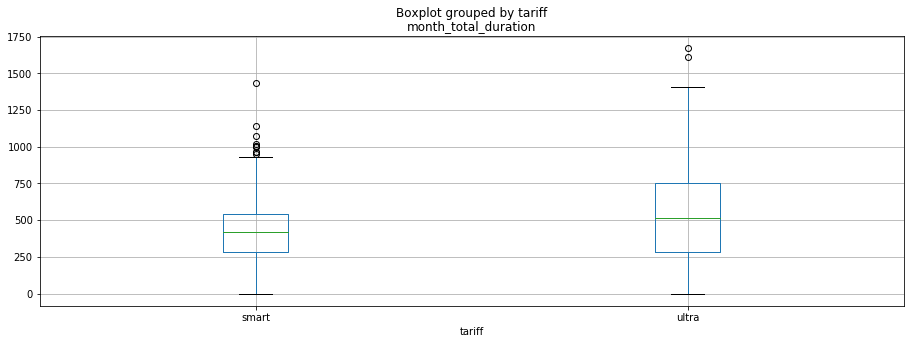

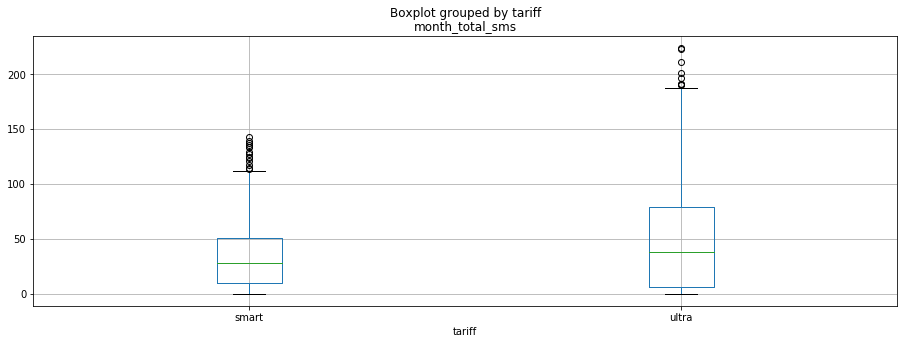

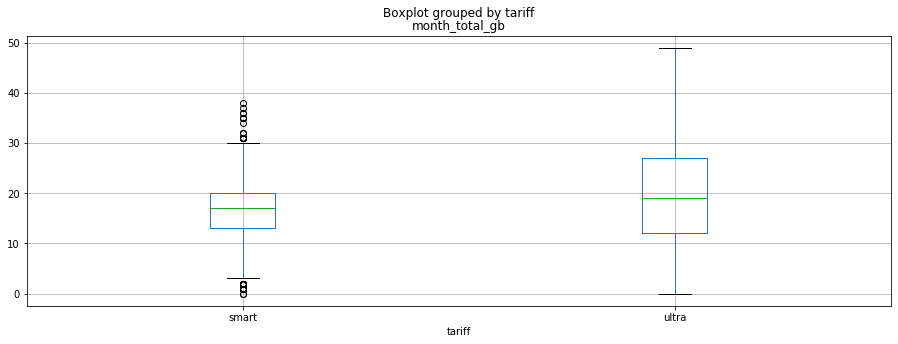

In [33]:
relevant_columns = ['month_total_duration', 'month_total_sms', 'month_total_gb']
for relevant_column in relevant_columns:
    df.boxplot(relevant_column, by='tariff',figsize=(15,5))

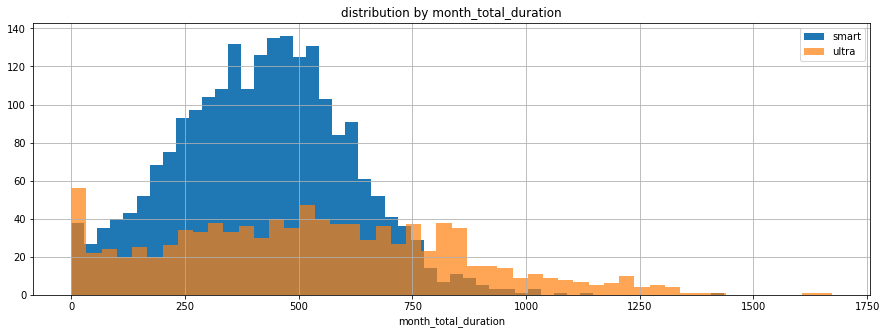

In [34]:
ax = df[df['tariff'] == 'smart']['month_total_duration'].hist(bins=50)
df[df['tariff'] == 'ultra']['month_total_duration'].hist(ax=ax, bins=50, grid=True, figsize=(15,5), alpha=0.7)
plt.title('distribution by month_total_duration')
plt.xlabel('month_total_duration')
plt.legend(['smart', 'ultra'])

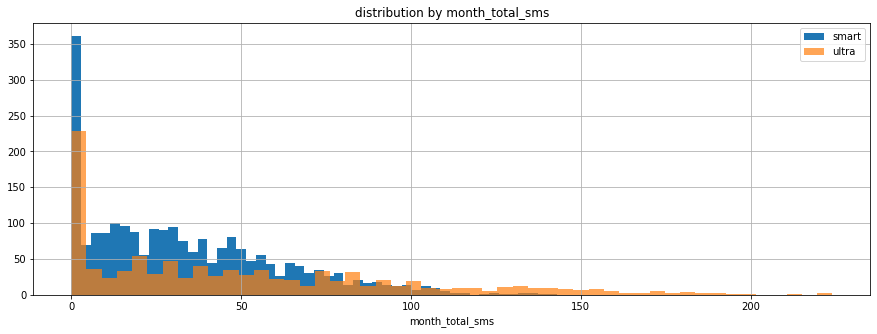

In [35]:
ax = df[df['tariff'] == 'smart']['month_total_sms'].hist(bins=50)
df[df['tariff'] == 'ultra']['month_total_sms'].hist(ax=ax, bins=50, grid=True, figsize=(15,5), alpha=0.7)
plt.title('distribution by month_total_sms')
plt.xlabel('month_total_sms')
plt.legend(['smart', 'ultra'])

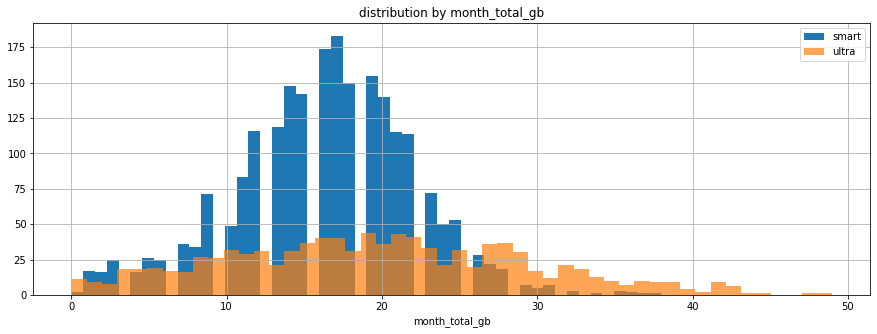

In [36]:
ax = df[df['tariff'] == 'smart']['month_total_gb'].hist(bins=50)
df[df['tariff'] == 'ultra']['month_total_gb'].hist(ax=ax, bins=50, grid=True, figsize=(15,5), alpha=0.7)
plt.title('distribution by month_total_gb')
plt.xlabel('month_total_gb')
plt.legend(['smart', 'ultra'])

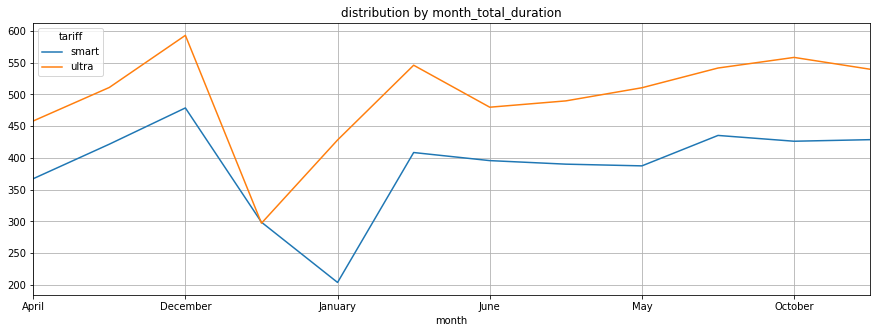

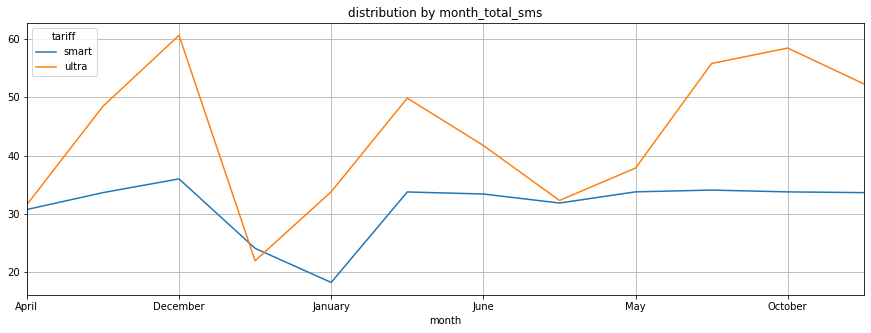

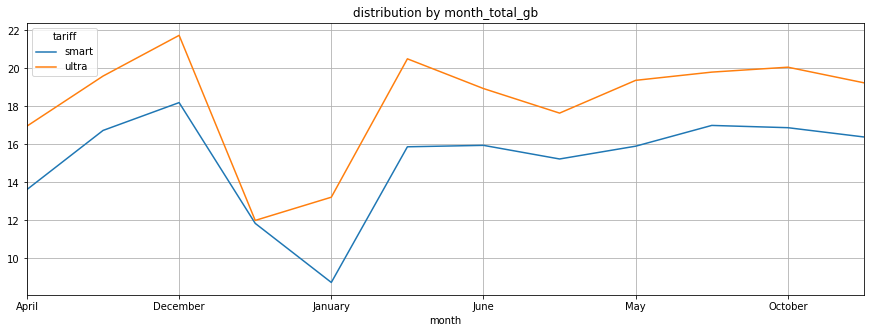

In [37]:
for relevant_column in relevant_columns:
    df.pivot_table(index='month', columns='tariff', values=relevant_column)\
    .sort_values(by='month', ascending='False')\
    .plot( grid=True, figsize=(15,5))
    plt.title(f'distribution by {relevant_column}')

Поскольку мы работаем с выборкой, генеральная совокупность недостижима. 500 наблюдений - достаточно большой объем для игнорирования ddof при расчете дисперсии и стандартного отклонения. Найдем значения дисперсии и стандартного отклонения для каждого из показателей.

In [38]:
relevant_columns = ['month_total_duration', 'month_total_sms', 'month_total_gb', 'total_paid']
for relevant_column in relevant_columns:
    print(df.groupby('tariff').agg({relevant_column:['median','mean','var','std']}))
    print()

       month_total_duration                                       
                     median        mean            var         std
tariff                                                            
smart                 422.0  417.934948   36219.315784  190.313730
ultra                 518.0  526.623350  100873.633397  317.606098

       month_total_sms                                   
                median       mean          var        std
tariff                                                   
smart             28.0  33.384029   796.812958  28.227876
ultra             38.0  49.363452  2285.266143  47.804457

       month_total_gb                                
               median       mean        var       std
tariff                                               
smart            17.0  16.328847  33.028705  5.747061
ultra            19.0  19.494416  97.091686  9.853511

       total_paid                                        
           median         mean            va

### Вывод

Рассматривая каждый тарифный плат по отдельности, можно заметить следующее:
- пользователи тарифа "smart" обычно тратят на звонки 450-500 мин/месяц, что соответствует лимиту на месяц;
- пользователи тарифа "ultra" обычно тратят на звонки около 750 мин/месяц, что не превышает лимит на месяц, однако у пользователей ежемесячно сгорает более 50% пакета минут, что не рентабельно;
- по кол-ву СМС-сообщений пользователи обоих тарифных планов не показывают особой заинтересованности в данном средстве связи (большинство клиентов отправляет не более 20 СМС в месяц, соответственно, по каждому из тарифов сгорает больше половины пакета СМС-сообщений);
- пользователи обоих тарифных планов обычно расходуют около 20 Гб/месяц, с той лишь разницец, что клиентам "smart" приходятся доплачивать за дополнительные Гб (в среднем не хватает 5 Гб), у клиентов "ultra" трафик в запасе и в большинстве случаев его хватает на месяц.

## Проверка гипотез

В рамках анализа необходимо проверить 2 гипотизы касательно выручки «Мегалайн». 

Проверку гипотез будем производить при помощи t-тестов, поскольку выборки для гипотез предсавляют собой независимые массивы данных.

Установим критический уровень статистической значимости в размере 5%.

In [39]:
alpha = .05

Чтобы проверить гипотезы, данные должны быть очищены от выбросов, поскольку согласно правилу 3х сигм, около 99% всех значений находятся в промежутке 6 сигм.

In [40]:
def rare_values(df, col): # создадим функцию для определения межквартильного размаха, 
    q1 = df[col].quantile(0.25) #границ размаха для исключения выбросов
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    bot_border = q1 - iqr*1.5
    top_border = q3 + iqr*1.5
    rare_values_bot = df.query(f'{col} < @bot_border')[col].count()
    rare_values_top = df.query(f'{col} > @top_border')[col].count()
    perc = ((rare_values_bot + rare_values_top) / df[col].count() * 100).round(1)
    return (f'Первый квартиль = {q1}, Третий квартиль = {q3}\n'
            f'Нижняя граница = {bot_border}, Верхняя граница = {top_border}\n'
            f'Редкие значения до нижней границы = {rare_values_bot}\n'
            f'Редкие значения выше верхней границы = {rare_values_top}\n'
            f'Процент редких значений = {perc}'
           )

In [41]:
print(rare_values(df, 'total_paid')) #определяем значения, которые стоит убрать

Первый квартиль = 750.0, Третий квартиль = 1950.0
Нижняя граница = -1050.0, Верхняя граница = 3750.0
Редкие значения до нижней границы = 0
Редкие значения выше верхней границы = 35
Процент редких значений = 1.1


In [42]:
df_new = df[df['total_paid'] <= 3750] #создаем новый датасет уже без учета редких значений
df_new.describe()

,user_id,month_total_duration,month_total_calls,month_total_sms,month_total_gb,age,rub_monthly_fee,above_the_tariff,total_paid
count,3179.000000,3179.000000,3179.000000,3179.000000,3179.000000,3179.000000,3179.000000,3179.000000,3179.000000
mean,1251.634162,448.285624,62.631960,38.239383,17.105694,46.718465,979.380308,517.658069,1497.038377
std,144.794609,239.606163,32.939182,36.015244,7.168354,16.598193,645.674936,697.984434,737.994878
min,1000.000000,0.000000,0.000000,0.000000,0.000000,18.000000,550.000000,0.000000,550.000000
25%,1124.500000,281.000000,40.000000,9.000000,13.000000,32.000000,550.000000,0.000000,750.000000
50%,1253.000000,440.000000,62.000000,30.000000,17.000000,47.000000,550.000000,150.000000,1612.000000
75%,1379.000000,585.500000,82.000000,57.000000,21.000000,62.000000,1950.000000,893.000000,1950.000000
max,1499.000000,1673.000000,244.000000,224.000000,42.000000,75.000000,1950.000000,3200.000000,3750.000000


Мы готовы приступить к проверке гипотез.

### Гипотиза "Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются "

Пойдем методом от обратного. Предположим, что средняя выручка пользователей тарифов «Ультра» совпадает с тарифом «Смарт». Так,

H0: выручка пользователей тарифов «Ультра» и «Смарт» не различается

H1: выручка пользователей тарифов «Ультра» и «Смарт» различается

In [43]:
ultra = df_new[df_new['tariff'] == 'ultra'] #формируем выборку по тарифному плану
smart = df_new[df_new['tariff'] == 'smart']
ultra = ultra['total_paid'] #формируем массив по выручке
smart = smart['total_paid']

In [44]:
results = st.ttest_ind(ultra, smart) #используем метод для 2хнезависимых выборок
print('p-value:', results.pvalue) #выводим уровень значимости 

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-value: 1.1481243947765852e-198
Отвергаем нулевую гипотезу


#### Вывод

По наблюдаемым данным можно предположить, что средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.

### Гипотиза "Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов"

Пойдем методом от обратного. Предположим, что средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов. Так,

H0: средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов

H1: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

In [45]:
df_new['city'].unique()#проверяем значения городов,чтобы корректно объединить данные по принципу Москва - Регион

array(['Краснодар', 'Москва', 'Стерлитамак', 'Новокузнецк',
       'Набережные Челны', 'Ульяновск', 'Челябинск', 'Пермь', 'Тюмень',
       'Самара', 'Санкт-Петербург', 'Иваново', 'Чебоксары', 'Омск', 'Уфа',
       'Томск', 'Чита', 'Мурманск', 'Петрозаводск', 'Тверь',
       'Екатеринбург', 'Махачкала', 'Вологда', 'Череповец', 'Ярославль',
       'Сочи', 'Хабаровск', 'Ставрополь', 'Рязань', 'Улан-Удэ', 'Тула',
       'Саратов', 'Ростов-на-Дону', 'Казань', 'Иркутск', 'Курск',
       'Калуга', 'Якутск', 'Астрахань', 'Химки', 'Владикавказ',
       'Волгоград', 'Саранск', 'Ижевск', 'Новосибирск', 'Брянск',
       'Тольятти', 'Нижний Тагил', 'Орёл', 'Белгород', 'Воронеж',
       'Курган', 'Барнаул', 'Красноярск', 'Архангельск', 'Липецк',
       'Кемерово', 'Киров', 'Сургут', 'Пенза', 'Волжский', 'Магнитогорск',
       'Нижний Новгород', 'Кострома', 'Владивосток', 'Тамбов', 'Балашиха',
       'Севастополь', 'Калининград', 'Оренбург', 'Смоленск',
       'Нижневартовск', 'Владимир', 'Новороссий

In [46]:
df_new['region'] = np.where(df_new['city'] == 'Москва', 'Москва', 'Регион') #присваиваем признак Москва - Регион
moscow = df_new[df_new['region'] == 'Москва'] #формируем выборку по городу
region = df_new[df_new['region'] == 'Регион']
moscow = moscow['total_paid'] #формируем массив по выручке
region = region['total_paid']

In [47]:
results = st.ttest_ind(moscow, region) #используем метод для 2хнезависимых выборок
print('p-value:', results.pvalue) #выводим уровень значимости

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-value: 0.2465723257484849
Не получилось отвергнуть нулевую гипотезу


#### Вывод

По наблюдаемым данным нельзя отвергнуть предположение, что средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов.

## Общий вывод

Таким образом, был проведен статистический анализ данных тарифов «Мегалайн» (федерального оператора сотовой связи)  на небольшой выборке клиентов.

Ситуация на данный момент:
- пользователи тарифа "smart" обычно тратят на звонки 450-500 мин/месяц, что соответствует лимиту на месяц;
- пользователи тарифа "ultra" обычно тратят на звонки около 750 мин/месяц, что не превышает лимит на месяц, однако у пользователей ежемесячно сгорает более 50% пакета минут, что не рентабельно;
- по кол-ву СМС-сообщений пользователи обоих тарифных планов не показывают особой заинтересованности в данном средстве связи (большинство клиентов отправляет не более 20 СМС в месяц, соответственно, по каждому из тарифов сгорает больше половины пакета СМС-сообщений);
- пользователи обоих тарифных планов обычно расходуют около 20 Гб/месяц, с той лишь разницец, что клиентам "smart" приходятся доплачивать за дополнительные Гб (в среднем не хватает 5 Гб), у клиентов "ultra" трафик в запасе и в большинстве случаев его хватает на месяц.

По наблюдаемым данным можно предположить, что средняя выручка пользователей тарифов «Ультра» и «Смарт» различается. Первые пользователи в основном не выходят за пределы тарифного плана и в среднем приносят «Мегалайн» ещемесячно 1950, как и прописано в тарифах. Вторые пользователи чаще выходят за лимиты пакета услуг и доплачивают за услуги связи, принося компании в среднем 1000, что на 50% больше ежемесячной платы. такая ситуация может привести к оттоку клиентов, необходимо обратить внимание на данный аспект.

По наблюдаемым данным нельзя отвергнуть предположение, что средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов.

### Рекомендации

При корректировке рекламного бюджета коммерческому департаменту следует учесть огромные переплаты клиентов по тарифу "Смарт" и сгорающие минуты, СМС и ГБ у тарифа "Ультра".